In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

In [2]:
data = loadmat('ex4/ex4data1.mat')

In [3]:
X, y = data['X'].T, data['y'].T
y[y==10] = 0 # set zeros equal to 0, not 10

In [4]:
def one_hot(a):
    """One hot encode variable and return its transpose: k x M , k-features, M-examples"""
    one_hot_encoded = np.zeros( (a.size, len(np.unique(a))) )
    one_hot_encoded[np.arange(a.size), a] = 1
    return one_hot_encoded.T

In [5]:
# We need to one-hot encode our output to vector
y_matrix = one_hot(y)

In [6]:
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
output_layer_size = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat('ex4/ex4weights.mat')
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z) )

In [8]:
def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

### Note all shapes for easier coding:
1. X - 400,5000
1. y - 10,5000
1. W1 - 25,400
1. b1 - 25,1
1. W2 - 10,25
1. b2 - 10,1

In [9]:
def forward_propagation(W1, b1, W2, b2, X):
    """feed forward nn. Returns of all layer values"""
    a1 = X
    a2 = W1@a1 + b1
    z2 = sigmoid(a2)
    a3 = W2@a2 + b2
    z3 = sigmoid(a3)
    return a1, a2, z2, a3, z3    

In [10]:
def backwards_propagations(a1, a2, z2, a3, z3, W1, W2, y, lambda_=0):
    """backwards propogation of nn"""
    m = y.shape[1]
    dZ3 = z3 - y # We find how much we missed predictions by
    
    dW2 = 1/m * dZ3@(a2.T) + (lambda_/m)*W2 ## add the regularization term
                           # We multiply how wrong our answers were(dZ3) by what values we got(a2),
                           # and get the needed adjustment. If we want to regularize, we add the term
    db2 = 1/m * np.sum(dZ3, 1) # We adjust the weight of bias based on average needed to account 
    db2 = np.reshape(db2,(db2.size,1)) # for wrong answers(dZ3). We also reshape to retain 2d matrix
    dZ2 =  W2.T@dZ3 * sigmoid_grad(z2) # We back propagate final error by multiplying it with
                                       # incoming weights to get second layer error and adjust with
                                       # cost function derivative
    # Other adjustments follow the same principle
    dW1 = 1/m * dZ2@(a1.T) + (lambda_/m)*W1
    db1 = 1/m * np.sum(dZ2, 1)
    db1 = np.reshape(db1,(db1.size,1))         
    return dW1, db1, dW2, db2

In [11]:
def init_weights(matrix_shapes):
    return [np.random.rand(i,j) for i,j in matrix_shapes]

In [12]:
def update_weights(weights, weight_deltas, alpha):
    return [w - wd*alpha for w, wd in zip(weights, weight_deltas)]

In [13]:
def prediction(z3):
    return np.argmax(z3,0)

In [14]:
def calculate_accuracy(z3,y):
    return np.sum(prediction(z3) == y) / y.size 

In [15]:
def return_wrong_example_mask(z3,y):
    return prediction(z3) != y

In [16]:
def gradient_descent(X,y, iterations, alpha=0.1, lambda_=0, X_test = None, y_test = None):
    W1, b1, W2, b2 = init_weights([(hidden_layer_size, input_layer_size), (hidden_layer_size,1),
                                  (output_layer_size,hidden_layer_size), (output_layer_size,1)])
    y_one_hot = one_hot(y)
    if X_test is not None and y_test is not None:
        y_test_one_hot = one_hot(y_test)
    
    accuracy_hist = []
    test_hist = []
        
    for i in range(iterations):
        a1, a2, z2, a3, z3 = forward_propagation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backwards_propagations(a1, a2, z2, a3, z3, W1, W2, y_one_hot, lambda_)
        W1, b1, W2, b2 = update_weights([W1, b1, W2, b2], [dW1, db1, dW2, db2], alpha)
        
        
        if i%100==0:
            print(f"Iteration {i}, Train Accuracy: {calculate_accuracy(z3,y)}")
            accuracy_hist.append(calculate_accuracy(z3,y))
            if X_test is not None and y_test is not None:
                test_params = forward_propagation(W1, b1, W2, b2, X_test)
                print(f"Test Accuracy: {calculate_accuracy(test_params[4],y_test)}")
                test_hist.append(calculate_accuracy(test_params[4],y_test))
            
            
    return W1, b1, W2, b2, [accuracy_hist,test_hist]

In [17]:
def gradient_descent_w_cost_func(weights, X,y, alpha=0.1, lambda_=0):
    epsilon = 1e-5
    m = y.size
    W1, b1, W2, b2 = unflatten_weights(weights)
    y_one_hot = one_hot(y)
    a1, a2, z2, a3, z3 = forward_propagation(W1, b1, W2, b2, X)
    dW1, db1, dW2, db2 = backwards_propagations(a1, a2, z2, a3, z3,W1, W2, y_one_hot)
    W1, b1, W2, b2 = update_weights([W1, b1, W2, b2], [dW1, db1, dW2, db2], alpha)
    reg_term = lambda_/(2*m) * ( np.sum(np.square(W1)) + np.sum(np.square(W2)) )

    J = (-1 / m) * np.sum( (np.log(z3+epsilon) * y_one_hot) + np.log(1 - z3+epsilon) * (1 - y_one_hot) ) + reg_term
    return J, np.concatenate([w.flatten() for w in [W1, b1, W2, b2]])

In [18]:
def unflatten_weights(flat_W):
    temp_w = flat_W[:input_layer_size*hidden_layer_size]
    W1 = np.reshape(temp_w,(hidden_layer_size,input_layer_size))
    temp_w =  flat_W[input_layer_size*hidden_layer_size:]
    b1 = np.reshape(temp_w[:hidden_layer_size],(hidden_layer_size,1))
    temp_w =  temp_w[hidden_layer_size:]
    W2 = np.reshape(temp_w[:hidden_layer_size*output_layer_size],(output_layer_size,hidden_layer_size))
    temp_w = temp_w[hidden_layer_size*output_layer_size:]
    b2 = np.reshape(temp_w[:output_layer_size],(output_layer_size,1))
    
    return W1, b1, W2, b2
    

In [19]:
start_weights = init_weights([(hidden_layer_size, input_layer_size), (hidden_layer_size,1),
                                  (output_layer_size,hidden_layer_size), (output_layer_size,1)])
flat_weights = np.concatenate([w.flatten() for w in start_weights])

In [20]:
X_train, X_test, y_train, y_test = [samp.T for samp in train_test_split(X.T, y.T, test_size=0.2)]

In [21]:
options= {'maxiter': 2000}
lambda_gd = lambda w : gradient_descent_w_cost_func(w, X_train, y_train)
res = minimize(lambda_gd,
                        flat_weights,
                        jac=True,
                        method='TNC',
                        options=options)

nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
weights_fin = nn_params
tained_weights_cost = unflatten_weights(weights_fin)

In [22]:
tained_weights_and_history = gradient_descent(X_train,y_train,10000,0.1,0,X_test,y_test)
print('------------------------')
tained_weights_and_history_regularized = gradient_descent(X_train,y_train,10000,0.1,1,X_test,y_test)

Iteration 0, Train Accuracy: 0.10025
Test Accuracy: 0.1


C:\Users\juliu\AppData\Local\Temp/ipykernel_27364/3401721323.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z) )


Iteration 100, Train Accuracy: 0.39175
Test Accuracy: 0.533
Iteration 200, Train Accuracy: 0.6705
Test Accuracy: 0.589
Iteration 300, Train Accuracy: 0.728
Test Accuracy: 0.724
Iteration 400, Train Accuracy: 0.77175
Test Accuracy: 0.775
Iteration 500, Train Accuracy: 0.82175
Test Accuracy: 0.751
Iteration 600, Train Accuracy: 0.83875
Test Accuracy: 0.791
Iteration 700, Train Accuracy: 0.8495
Test Accuracy: 0.803
Iteration 800, Train Accuracy: 0.85925
Test Accuracy: 0.818
Iteration 900, Train Accuracy: 0.86875
Test Accuracy: 0.828
Iteration 1000, Train Accuracy: 0.872
Test Accuracy: 0.834
Iteration 1100, Train Accuracy: 0.87725
Test Accuracy: 0.843
Iteration 1200, Train Accuracy: 0.884
Test Accuracy: 0.849
Iteration 1300, Train Accuracy: 0.88675
Test Accuracy: 0.855
Iteration 1400, Train Accuracy: 0.88775
Test Accuracy: 0.856
Iteration 1500, Train Accuracy: 0.88925
Test Accuracy: 0.857
Iteration 1600, Train Accuracy: 0.89375
Test Accuracy: 0.861
Iteration 1700, Train Accuracy: 0.89625
T

Iteration 3800, Train Accuracy: 0.92475
Test Accuracy: 0.887
Iteration 3900, Train Accuracy: 0.9255
Test Accuracy: 0.887
Iteration 4000, Train Accuracy: 0.92625
Test Accuracy: 0.888
Iteration 4100, Train Accuracy: 0.9275
Test Accuracy: 0.888
Iteration 4200, Train Accuracy: 0.928
Test Accuracy: 0.888
Iteration 4300, Train Accuracy: 0.9285
Test Accuracy: 0.888
Iteration 4400, Train Accuracy: 0.92925
Test Accuracy: 0.887
Iteration 4500, Train Accuracy: 0.92975
Test Accuracy: 0.887
Iteration 4600, Train Accuracy: 0.93
Test Accuracy: 0.886
Iteration 4700, Train Accuracy: 0.9305
Test Accuracy: 0.885
Iteration 4800, Train Accuracy: 0.9305
Test Accuracy: 0.884
Iteration 4900, Train Accuracy: 0.931
Test Accuracy: 0.884
Iteration 5000, Train Accuracy: 0.931
Test Accuracy: 0.884
Iteration 5100, Train Accuracy: 0.9315
Test Accuracy: 0.884
Iteration 5200, Train Accuracy: 0.9315
Test Accuracy: 0.883
Iteration 5300, Train Accuracy: 0.9315
Test Accuracy: 0.883
Iteration 5400, Train Accuracy: 0.932
Tes

In [25]:
# Trained with minimization from Sci-kit and cost function
# prediction_1 = forward_propagation(*tained_weights_cost,X_test)
# accuracy_1 = calculate_accuracy(prediction_1[4],y_test)
# print(f"Model trained with minimization scored {accuracy_1} on test set")
# For some reasone it does not work
*trained_weight_1, history_of_accuracy_1 = tained_weights_and_history
prediction_1 = forward_propagation(*trained_weight_1,X_test)
accuracy_1 = calculate_accuracy(prediction_1[4],y_test)
print(f"Model trained with manual gradient descent {accuracy_1} on test set")
*trained_weight_2, history_of_accuracy_2 = tained_weights_and_history_regularized
prediction_2 = forward_propagation(*trained_weight_2,X_test)
accuracy_2= calculate_accuracy(prediction_2[4],y_test)
print(f"Model trained with manual gradient descent and regularization {accuracy_1} on test set")

Model trained with manual gradient descent 0.889 on test set
Model trained with manual gradient descent and regularization 0.889 on test set


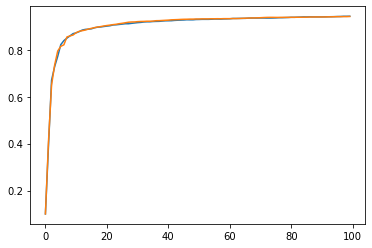

In [31]:
plt.plot(history_of_accuracy_1[0])
plt.plot(history_of_accuracy_2[0])

We see a high accuracy and no decrease in validation(test) set after any number of itterations, thus we can conclude, that the model is propperly trained and does not overfit

Lets look at the examples the model fails to predict

In [32]:
wrong_examples = return_wrong_example_mask(prediction_1[4],y_test)

In [33]:
wrong_prediction_input = X_test[:,wrong_examples.reshape(-1)].T
wrong_prediction_output = y_test[:,wrong_examples.reshape(-1)].T

In [34]:
def see_prediction(i, o):
    sample = np.random.randint(low=0, high=len(o))
    i_samp, o_samp = i[sample], o[sample]
    example = np.reshape(i_samp,(20,20))
    plt.imshow(example)
    print(o_samp)

[8]


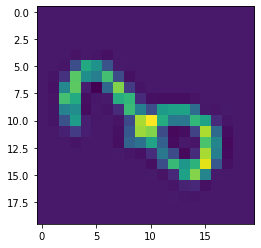

In [35]:
see_prediction(wrong_prediction_input,wrong_prediction_output)

Looking at some examples, we can clearly see that not even a human could verify that the written number corresponds to the actual value

We either have incorrect labels for some examples or corrupt dataset